# Rapport de projet de détection et de reconnaissance faciale

## Détection de visage - Cascade de Haar

### 1 - Détection à partir d'une image ou d'un flux vidéo

Le code suivant permet de détecter un visage en prenant comme entrée la webcam de l'ordinateur.

In [3]:
import cv2
import numpy as np
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")  # On charge le classifieur de visage

video_capture = cv2.VideoCapture(0) # On ouvre la webcam
while True:
    ret, frame = video_capture.read()   # On récupère une image de la webcam
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)    # On la convertit en niveaux de gris
    face = face_classifier.detectMultiScale(frame_gray, scaleFactor=1.1, minNeighbors=5, minSize=(40, 40))  # On détecte les visages
    if len(face) != 0:  # Si on a détecté des visages
        for (x, y, w, h) in face:
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)    # On dessine un rectangle autour de chaque visage
    cv2.imshow('Video', frame)  # On affiche l'image
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video_capture.release()
cv2.destroyAllWindows()

### 2 - Evaluation des performances

On reprend le code pour détecter des visages dans une image, et on évalue ses performances.

At image 0 , we have:
Average IoU (including false positive and undetected faces): 0.5349095799362508
Average IoU not null (only sucessfuly detected faces): 0.5349095799362508
Precision (Ratio between successful detection and total detections): 1.0
Recall (Ratio between successful detection and total faces): 1.0


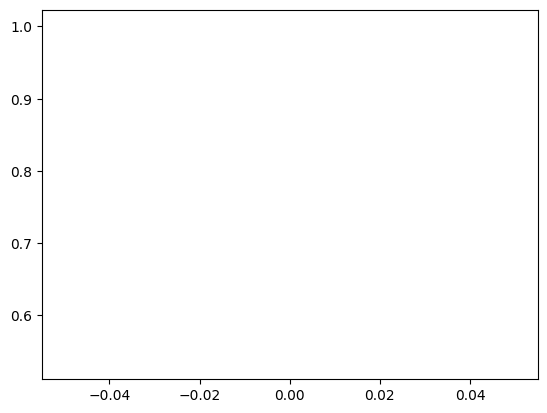

KeyboardInterrupt: 

: 

In [4]:

image_dir = 'images/train'
result_dir = 'labels2'
result_files = os.listdir(result_dir)
IoUresults = []
avgIoU = []
avgIoUNotNull = []
avgPrecision = []
avgRecall = []
totalIoU = 0
IoUNotNull = 0
totalCount = 0
NotNullCount = 0
CountNotDetected = 0
# Pour chaque image
for i in range(0, len(os.listdir(image_dir))):
    filename = os.listdir(image_dir)[i]
    image_path = os.path.join(image_dir, filename)
    image = cv2.imread(image_path) # On charge l'image

    frame_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # On la convertit en niveaux de gris
    face = face_classifier.detectMultiScale(frame_gray, scaleFactor=1.1, minNeighbors=5, minSize=(40, 40)) # On détecte les visages

    result_path = os.path.join(result_dir, filename.replace('.jpg', '.txt').replace('.png', '.txt')) # On récupère le fichier de résultat
    result = open(result_path, "r").read().splitlines()
    result = [list(map(str, x.split())) for x in result]

    # Pour chaque visage détecté
    IoU = []
    for (x, y, w, h) in face:
        x1, y1, x2, y2 = x, y, x+w, y+h # On récupère les coordonnées du visage
        currentIoU = 0
        for rect in result:
            _, _, x1_val, y1_val, x2_val, y2_val = rect # On récupère les coordonnées indiquées dans le fichier de résultat
            x1_val, y1_val, x2_val, y2_val = float(x1_val), float(y1_val), float(x2_val), float(y2_val)
            # On cherche les coordonnées du coin supérieur gauche et inférieur droit du rectangle d'intersection
            x1_i = max(x1, x1_val)
            y1_i = max(y1, y1_val)
            x2_i = min(x2, x2_val)
            y2_i = min(y2, y2_val)
            # On vérifie que le rectangle d'intersection est valide
            if x1_i < x2_i and y1_i < y2_i:
                # On calcule la surface du rectangle d'intersection
                surface = (x2_i - x1_i) * (y2_i - y1_i)
                # On calcule la surface de l'union du rectangle prédit et du rectangle détecté
                union = (x2 - x1) * (y2 - y1) + (x2_val - x1_val) * (y2_val - y1_val) - surface
                newIoU = surface / union # On calcule l'IoU
                # Si l'IoU est supérieur à l'IoU actuel, on le met à jour (on cherche le meilleur match entre les visages détectés et les visages prédits)
                if newIoU > currentIoU:
                    currentIoU = newIoU
        IoU.append(currentIoU)
        totalIoU += currentIoU
        totalCount += 1
        if currentIoU > 0: # Si l'IoU est non nul, on a détecté un visage avec succès
            IoUNotNull += currentIoU
            NotNullCount += 1
    if len(IoU) < len(result):
        for j in range(len(IoU), len(result)): # Si on n'a pas détecté tous les visages, on ajoute des 0 à l'IoU
            IoU.append(0)
            CountNotDetected += 1
    IoUresults.append(IoU)

    avgIoU.append(totalIoU/(totalCount+CountNotDetected))
    avgIoUNotNull.append(IoUNotNull/NotNullCount)
    avgPrecision.append(NotNullCount/totalCount)
    avgRecall.append(NotNullCount/(NotNullCount+CountNotDetected))
    if i%100 == 0:
        print("At image", i, ", we have:")
        print("Average IoU (including false positive and undetected faces):", totalIoU/(totalCount+CountNotDetected))
        print("Average IoU not null (only sucessfuly detected faces):", IoUNotNull/NotNullCount)
        print("Precision (Ratio between successful detection and total detections):", NotNullCount/totalCount)
        print("Recall (Ratio between successful detection and total faces):", NotNullCount/(NotNullCount+CountNotDetected))

    if i%1000 == 0:
        plt.plot(avgIoU)
        plt.plot(avgIoUNotNull)
        plt.plot(avgPrecision)
        plt.plot(avgRecall)
        plt.show()


    if len(face) != 0:
        for i in range (0, len(face)):
            (x, y, w, h) = face[i]
            if IoU[i] > 0.5:
                cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)    # On dessine un rectangle vert autour des visages bien détectés (IoU > 0.5)
            else:
                cv2.rectangle(image, (x, y), (x+w, y+h), (0, 0, 255), 2)    # On dessine un rectangle rouge autour des visages mal détectés (IoU <= 0.5)
    if len(result) != 0:
        for (_, _, x, y, w, h) in result:
            x, y, w, h = float(x), float(y), float(w), float(h)
            cv2.rectangle(image, (int(x), int(y)), (int(w), int(h)), (255, 0, 0), 2)    # On dessine un rectangle bleu autour des visages prédits
    cv2.imshow('Image', image)
    cv2.waitKey(0)

average_IoU = np.mean(IoUresults)
print("Average IoU:", average_IoU)

Après avoir laissé tourner cet algorithme pour 2000 images, nous obtenons les résultats suivants :

![Resultats IoU](resultIoU3.png)

![Resultats IoU graphe](resultIoU2.png)

Avec en vert la précision, en orange l'IoU sans prendre en compte les non-détections, en rouge le rappel, et en bleu l'IoU prenant en compte les faux positifs et les non-détections.

# 3 - Interprétation

Nous voyons que dans 75% des cas où le modèle nous indique qu'il y a un visage, la prédiction se révèle juste (précision du modèle). Cela est un résultat prometteur, mais qui n'est pas complètement satisfaisant, avec un taux de 25% de faux-positifs.

Une autre statistique intéressante est le taux de rappel. Le modèle ne détecte que 45% des visages présents dans les photos. Ce résultat reste assez bas, et pourrait être grandement amélioré.

Enfin, l'IoU, qui est le rapport de surface entre les visages détectés et les visages prédits, a une valeur de 0.6 quand les visages sont détectés avec succès, ce qui signifie que le modèle parvient à déceler le visage de manière correcte. Encore une fois, c'est un score qui pourrait être largement amélioré.

Nous avons également calculé l'IoU de manière plus globale, en prenant en compte les faux positifs et les non-détections de visage. Cela fait naturellement descendre fortement l'IoU, avec un IoU à environ 0.25. Cela traduit un manque de finesse dans la détection des visages par le modèle.

Finalement, ces statistiques nous indiquent que le modèle est fonctionnel et parvient à détecter avec succès des visages dans des images, mais il n'est pas assez performant, et a un taux d'erreur encore très important. Cependant, il est intéressant de noter que l'un des avntages de ce modèle est sa rapidité.

## Reconnaissance de visages

### 1 - Méthode de l'ACP

Voici le code que nous avons utiliser pour implémenter la méthode de l'ACP pour la reconnsaissance de visages.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)  # On charge le dataset LFW avec un minimum de 70 images par personne et une taille de 0.4

# On en extrait les caractéristiques et les labels
X = lfw_people.data
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
print("Total dataset size: %d" % X.shape[0])

# Diviser les données en un ensemble d'entraînement et un ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

# Appliquer l'ACP pour réduire la dimensionnalité
n_components = 100  # Nombre de composantes principales (hyperparamètre à optimiser)
print("Number of components: ", n_components)
pca = PCA(n_components=n_components, whiten=True).fit(X_train)

X_train_pca = pca.transform(X_train)    # Appliquer la transformation aux données d'entraînement
X_test_pca = pca.transform(X_test)
eigenfaces = pca.components_.reshape((n_components, lfw_people.images.shape[1], lfw_people.images.shape[2]))    # Récupérer les eigenfaces
clf = SVC(kernel='rbf', class_weight='balanced')
clf = clf.fit(X_train_pca, y_train)

y_pred = clf.predict(X_test_pca) # On prédit les noms des personnes sur l'ensemble de test
print(classification_report(y_test, y_pred, target_names=target_names))     # Afficher les résultats de classification

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):   # Fonction pour afficher les images
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

def title(y_pred, y_test, target_names, i):     # Fonction pour afficher le nom prédit et le nom réel
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    if pred_name == true_name:
        return "Predicted: " + pred_name + "\nReality: " + true_name + "\nCorrect"
    else:
        return "Predicted: " + pred_name + "\nReality: " + true_name + "\nIncorrect"

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, lfw_people.images.shape[1], lfw_people.images.shape[2])
plt.show()


Après avoir testé plusieurs valeurs pour le nombre de composantes principales (25, 50, 100, 150, 200, 300), nous sommes arrivés à la conclusion que 100 semblait être l'hyperparamètre le plus adapté à notre situation.  
Cela permet en effet d'optimiser au mieux la valeur du F1-score (89%), qui est calculé comme étant `2 / (1/precision + 1/recall)`, et permettant d'avoir une métrique reliant la précision au taux de rappel. Plus le F1-score est élevé, plus le modèle est efficace (1.0 étant la valeur maximale théorique).  
Une valeur plus faible résulterait en un modèle moins entraîné, donc moins bon. Une valeur plus haute nuirait au modèle en l'hyperspécialisant.

Voici les résultats obtenus avec un tel hyperparamètre :

![resultat ACP](resultACP.png)

Nous voyons que le modèle a de bons résultats, avec une précision et un taux de rappel autour de 90%. Cela montre l'efficacité du modèle pour reconnaître des visages.